In [1]:
import scipy
from scipy.signal import savgol_filter
from SiFoN import smoothing as sm
from SiFoN import viz
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd

In this tutorial, we will review how to use the SiFoN.smoothing module. This module allows you to smooth Sei scores in multiple ways in order to improve predictions. As a case study, we analyze the the 12q24 breast cancer risk region identified by Beesley et al. in 2020 (https://doi.org/10.1186/s13059-019-1877-y). 



In this first step, we calculculate predictions for the high-impact SNP rs1391721, which Beesley et al. identified as a CCV that shows high binding activity with the transcription factors FOXA1 / AR / ESR1, a TF involved in mammary tissue regulation. Sei also shows high variant effect predictions for these TFs at this locus. We shift this SNP to different locations on the Sei 4k input sequence and observe periodicity of scores. We apply rolling average smoothing to a the TF3 FOXA1 / AR / ESR1 to remove periodicity. 

First, we 
* Read in Sei predictions
* Label SNPs based on where the SNP is in the 4kb input string
* Label which sequence class each prediction corresponds to

In [2]:
sequence_class_scores = \
    np.load("../../fasta_files.sc_scores/distance_from_center_alt_predictions.sequence_class_scores.npy")
size = 4096
snps = list(list(range(-size + 60, -60))*sequence_class_scores.shape[1])
snps.sort()
seqclass_names = pd.read_csv("../model_data/seqclass-names.txt", header=None, sep="\n")

In [3]:
raw_data = {"Raw Scores": sequence_class_scores.flatten(), 
           "Sequence Class": np.array((sequence_class_scores.shape[0]*list(seqclass_names[0]))),
           "Position": snps}
df = pd.DataFrame(raw_data)
df["Position"] = df["Position"].add(size/2)
print(len(df))
df.head(3)

159040


,Raw Scores,Sequence Class,Position
0,0.000980,PC1 Polycomb / Heterochromatin,-1988.0
1,0.002057,L1 Low signal,-1988.0
2,0.004911,TN1 Transcription,-1988.0


Now that we have our dataframe, we are going to analyze the TF3 FOXA1 / AR / ESR1 scores before and after smoothing

In [5]:
tf3_df = sm.smooth_class(df, sequence_class_name = "TF3 FOXA1 / AR / ESR1", window=15)
tf3_df.head(2)

/home/bmacedo/IW/SiFoN/src/SiFoN/smoothing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smooth_df["Smoothed Scores"] = smooth_df["Raw Scores"].rolling(window, center=True).mean().values


,Raw Scores,Sequence Class,Position,Smoothed Scores
299,-0.000184,TF3 FOXA1 / AR / ESR1,-1981.0,0.000048
339,-0.000133,TF3 FOXA1 / AR / ESR1,-1980.0,0.000019


We observe that smoothing reduces periodicity in scores

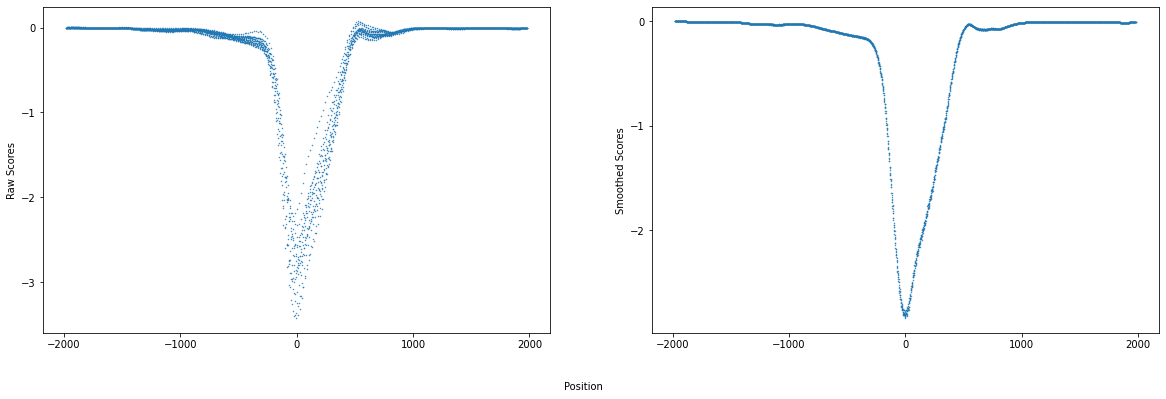

In [6]:
sm.plot_smooth_v_raw(tf3_df, figname="smooth_v_raw_TF3.png", sequence_class_name = "TF3 FOXA1 / AR / ESR1")

Next, we will smooth out an entire set of predictions for the 12q24 regions. 

In [7]:
vcf = pd.read_csv("../../beesley/beesley_ism/chr12_115750000_116000000.vcf", 
                  header=None, sep="\t", 
                  names=["Chromosome", "Position", "SNP", "Ref", "Alt"])
scores = viz.preprocess("../../beesley/beesley_ism/sequence_class_scores.npy", vcf)
scores.head(2)

,PC1 Polycomb / Heterochromatin,L1 Low signal,TN1 Transcription,TN2 Transcription,L2 Low signal,E1 Stem cell,E2 Multi-tissue,E3 Brain / Melanocyte,L3 Low signal,E4 Multi-tissue,...,E10 Brain,TF4 OTX2,HET4 Heterochromatin,L7 Low signal,PC4 Polycomb / Bivalent stem cell Enh,HET5 Centromere,E11 T-cell,TF5 AR,E12 Erythroblast-like,HET6 Centromere
Position,,,,,,,,,,,,,,,,,,,,,
115750001,0.003443,0.011996,-0.012885,-0.013221,0.013696,-0.007417,-0.021189,0.008216,0.005638,-0.030092,...,0.004580,-0.002850,0.004997,0.005615,-0.003649,0.002053,-0.010767,-0.005198,-0.011870,0.000524
115750002,0.005822,0.020055,0.013833,0.017974,0.018275,0.005754,-0.016489,0.011736,0.008189,-0.031737,...,0.006858,0.006303,0.004143,0.005939,0.006390,0.004964,0.009252,0.009120,0.007257,0.001949


This smoothing algorithm applies softmax across sequence class scores to dampen low scores and elevate high scores. You can set `sm` to False to turn off softmax. Then, it applies the Savitzky-Golay filtering method to highlight structure in the data. You can set `sav` to False to turn off Savitzky-Golay filtering. You can use the `window_length` and `polyorder` parameters to adjust the filtering parameters. 

In [8]:
smoothed_scores = sm.smooth_all_scores(scores, window_length = 801, polyorder = 4, sav = True, sm = True)

In [9]:
# we adjust the range of values to compare results to Beesley et al.'s data
smoothed_all_scores = smoothed_scores[smoothed_scores.index > 115800000]
scores = scores[scores.index > 115800000]

Finally, we plot the data. We find that the resulting smoothed scores resemble ATAC-seq binding tracks from in vivo studies (see Beesley et al. Figure 5: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1877-y/figures/5)

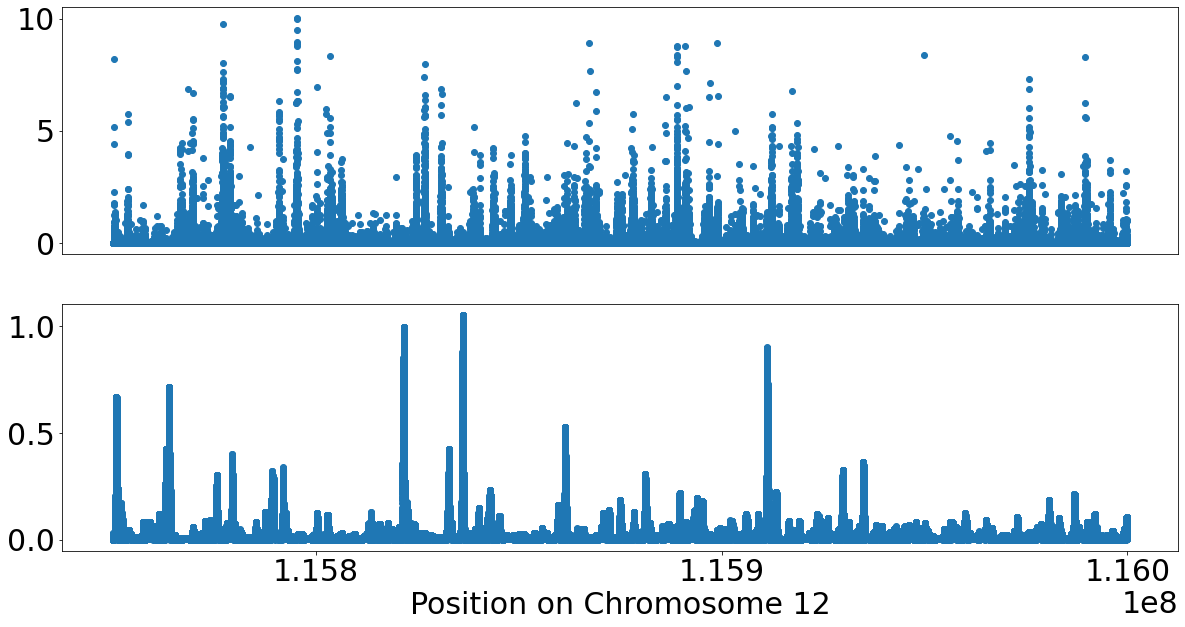

In [10]:
fig, (ax_raw, ax_smooth) = plt.subplots(2, 1, figsize=(20, 10))
ax_raw.scatter(scores.index, abs(scores["TF3 FOXA1 / AR / ESR1"].values))
ax_raw.set_xticks([])
ax_smooth.scatter(smoothed_scores.index, abs(smoothed_scores["TF3 FOXA1 / AR / ESR1"].values))
ax_smooth.set_xlabel("Position on Chromosome 12")
plt.locator_params(nbins=4)
plt.show()